## Imports

I like to keep my imports organized in a cell at the very top. This avoids multiple imports of the same libraries and makes it easy to find what I've imported.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder

## Intro

The idea of this notebook is to first analyze and understand the dataset used in [this competition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques). As a second step, I will prepare the dataset for training using common techniques such as **imputing** missing values, **scaling** the data appropriately, and **removing** any unnecessary features. Lastly, I will train a **simple** ML model to predict the pricing of any given apartment/house given several criteria.

The dataset is a modernized and expanded version of the famous Boston Housing dataset, which is why I chose it.

**Disclaimer:** I will use one of my notebooks as inspiration.

# Loading the Data

In [2]:
data_full = pd.read_csv('data/train.csv')
data_full.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# EDA - Getting an Overview

In [3]:
data_full.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
data_full.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

It's already clear that we need to remove our target, `SalePrice`, before training. Furthermore, the `Id` column is useless to us, as it merely functions as an offset index; we can drop this one now and handle SalePrice later when defining our X and y.

In [5]:
data_full.drop(columns = ['Id'], inplace = True)

In [6]:
# Creating a quick view of the NaN percentage per column
nan_counts = data_full.isna().sum()
total_counts = data_full.count()

nan_summary = pd.DataFrame({'NaNs': nan_counts, 'Total': total_counts})
nan_summary['NaN Proportion'] = nan_summary['NaNs'] / (nan_summary['NaNs'] + nan_summary['Total'])

contains_nan = nan_summary['NaN Proportion'] > 0
nan_summary[contains_nan].sort_values(by = 'NaN Proportion', ascending = False)

,NaNs,Total,NaN Proportion
PoolQC,1453,7,0.995205
MiscFeature,1406,54,0.963014
Alley,1369,91,0.937671
Fence,1179,281,0.807534
FireplaceQu,690,770,0.472603
LotFrontage,259,1201,0.177397
GarageType,81,1379,0.055479
GarageYrBlt,81,1379,0.055479
GarageFinish,81,1379,0.055479
GarageQual,81,1379,0.055479


Above we can already see that there's a lot of missing data in 5 of the columns. The next step is to analyze whether or not the missing data has meaning. We can look at the data description for this.

> PoolQC: Pool quality -> NA	means No Pool
> 
> Fence: Fence quality -> NA	means No Fence
> 
> MiscFeature: Miscellaneous feature not covered in other categories -> NA	means None
> 
> Alley: Type of alley access to property	 -> NA means 	No alley access
> 
> FireplaceQu: Fireplace quality -> NA	means No Fireplace

From the description above, that missing data has meaning and will most likely influence prices. To avoid any model errors and/or inconsistencies, I will later impute these values.

# Understanding our Features

Now, we need to understand our features. This means that we need to

1. Get a sense of numerical and categorical features
2. Find **all** the features where `NaN` means something (so we can impute properly)
3. Look at how our numerical features are distributed (helps to choose how to scale later)

Let's deal with numerical data first because it's both easier and will avoid problems after encoding categorical data (by which we inherently generate more numerical data).

## Numerical Features

Since we're going to start manipulating numerical data, it would be wise to remove `SalePrice` before moving on.

In [7]:
data = data_full.drop(columns = ['SalePrice'])

In [8]:
numerical_columns = data.select_dtypes(include = ['int', 'float']).columns.tolist()

print(f'Number of features: {len(numerical_columns)}')
numerical_columns

Number of features: 36


['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

`MSSubClass` immediately stands out: though the values are integers, the column is of a categorical (nominal) nature. We should deal with this now.

In [9]:
# Use apply to convert values to strings
data.MSSubClass = data.MSSubClass.apply(str)

In [10]:
numerical_columns = data.select_dtypes(include = ['int', 'float']).columns.tolist()

print(f'Number of features: {len(numerical_columns)}')
# numerical_columns

Number of features: 35


### Imputing

From our `NaN` overview above, some numerical columns have some missing data. Let's take a closer look

In [11]:
data[numerical_columns].isna().sum().sort_values(ascending = False)

LotFrontage      259
GarageYrBlt       81
MasVnrArea         8
WoodDeckSF         0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageCars         0
GarageArea         0
OpenPorchSF        0
HalfBath           0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
BedroomAbvGr       0
FullBath           0
LotArea            0
BsmtHalfBath       0
BsmtFullBath       0
GrLivArea          0
LowQualFinSF       0
2ndFlrSF           0
1stFlrSF           0
TotalBsmtSF        0
BsmtUnfSF          0
BsmtFinSF2         0
BsmtFinSF1         0
YearRemodAdd       0
YearBuilt          0
OverallCond        0
OverallQual        0
YrSold             0
dtype: int64

Apart from `LotFrontage`, which has 17% missing data, the other columns are fine. Let's impute those values using `mean`.

In [12]:
mean_imputer = SimpleImputer()

data[['LotFrontage', 'GarageYrBlt', 'MasVnrArea']] = mean_imputer.fit_transform(data[['LotFrontage', 'GarageYrBlt', 'MasVnrArea']])

### Scaling

Now we need to understand how our numbers are distributed to understand how best to scale the data.

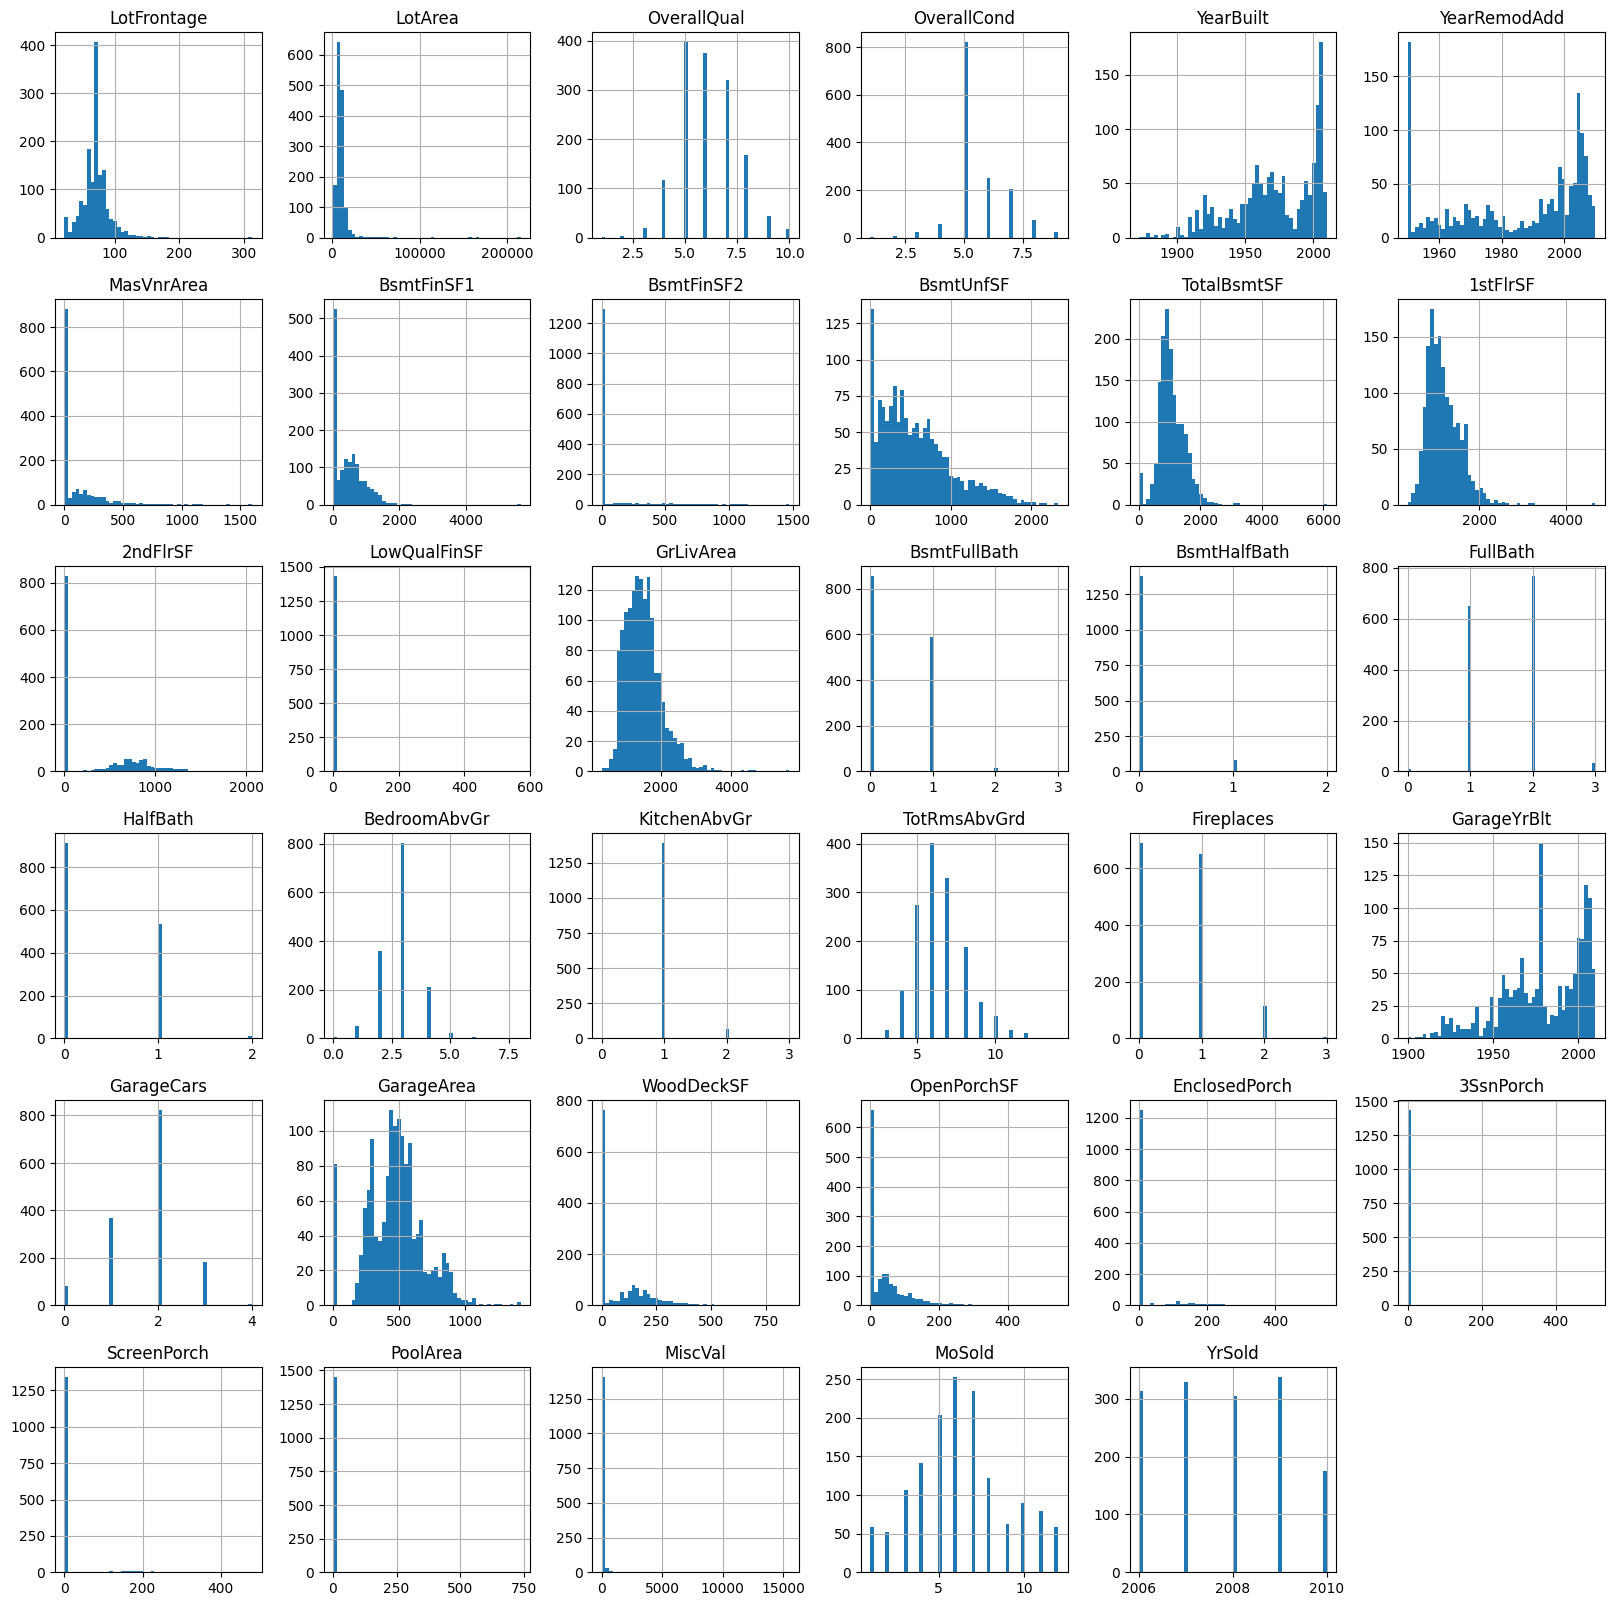

In [13]:
data[numerical_columns].hist(figsize = (20, 20), bins = 50);

It looks like a RobustScaler might be a safer option. With a bigger time investment, however, there's surely room for improvement here, although I would rather try tuning models before trying different scalers.

In [14]:
scaler = RobustScaler()

scaler.fit(data[numerical_columns])
data[numerical_columns] = scaler.transform(data[numerical_columns])

data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,-0.265787,-0.254076,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,-1.333333,0.0,WD,Normal
1,20,RL,0.523686,0.030015,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,-0.333333,-0.5,WD,Normal
2,60,RL,-0.107893,0.437624,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,1.000000,0.0,WD,Normal
3,70,RL,-0.528945,0.017663,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.0,0.0,NaN,NaN,NaN,0.0,-1.333333,-1.0,WD,Abnorml
4,60,RL,0.734213,1.181201,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,2.000000,0.0,WD,Normal


## Categorical Features

In [15]:
categorical_columns = data.select_dtypes(include = ['object']).columns.tolist()

print(f'Number of features: {len(categorical_columns)}')
categorical_columns

Number of features: 44


['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

### Imputing

Through a few minutes of manual inspection of the data's description file, we can make a list of features where `NaN` has meaning. These should be imputed.

In [16]:
nan_features = [
    'PoolQC',
    'MiscFeature',
    'Alley',
    'Fence',
    'FireplaceQu',
    'GarageType',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'BsmtFinType2',
    'BsmtExposure',
    'BsmtQual',
    'BsmtCond',
    'BsmtFinType1',
    'MasVnrType'
]

In [17]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,-0.265787,-0.254076,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,-1.333333,0.0,WD,Normal
1,20,RL,0.523686,0.030015,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,-0.333333,-0.5,WD,Normal
2,60,RL,-0.107893,0.437624,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,1.000000,0.0,WD,Normal
3,70,RL,-0.528945,0.017663,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.0,0.0,NaN,NaN,NaN,0.0,-1.333333,-1.0,WD,Abnorml
4,60,RL,0.734213,1.181201,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,2.000000,0.0,WD,Normal


In [18]:
nan_imputer = SimpleImputer(strategy = 'constant', fill_value = 'None')

# Fit the imputer only on relevant columns, then overwrite them
nan_imputer.fit(data[nan_features])
data[nan_features] = nan_imputer.transform(data[nan_features])

data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,-0.265787,-0.254076,Pave,None,Reg,Lvl,AllPub,Inside,...,0.0,0.0,None,None,None,0.0,-1.333333,0.0,WD,Normal
1,20,RL,0.523686,0.030015,Pave,None,Reg,Lvl,AllPub,FR2,...,0.0,0.0,None,None,None,0.0,-0.333333,-0.5,WD,Normal
2,60,RL,-0.107893,0.437624,Pave,None,IR1,Lvl,AllPub,Inside,...,0.0,0.0,None,None,None,0.0,1.000000,0.0,WD,Normal
3,70,RL,-0.528945,0.017663,Pave,None,IR1,Lvl,AllPub,Corner,...,0.0,0.0,None,None,None,0.0,-1.333333,-1.0,WD,Abnorml
4,60,RL,0.734213,1.181201,Pave,None,IR1,Lvl,AllPub,FR2,...,0.0,0.0,None,None,None,0.0,2.000000,0.0,WD,Normal


Aside from those features, there is only one categorical feature left with `NaN`s: `Electrical`

In [19]:
leftover_nans = data[categorical_columns].isna().sum().to_frame()

leftover_nans[leftover_nans[0] > 0]

,0
Electrical,1


In [20]:
imputer = SimpleImputer(strategy = 'most_frequent')

imputer.fit(data[['Electrical']])
data.Electrical = imputer.transform(data[['Electrical']])

data.Electrical.isna().sum()

0

### Encoding

The other thing we need to do is encode our features. We have two kinds: nominal and ordinal features.

It's not super quick, but here I would take the time to check which features are ordinal and manually encode them by creating a mapping dictionary and then replacing the values in the DF. I realize I could use an OrdinalEncoder from Sklearn here, but then I would have to watch the order of the categories much more closely, it's more prone to errors.

In [21]:
ordinal_mappings = {
    'BsmtCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4},
    'BsmtQual': {'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
    'BsmtFinType1': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'BsmtFinType2': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'Electrical': {'Mix': 0, 'FuseP': 1, 'FuseF': 2, 'FuseA': 3, 'SBrkr': 4},
    'ExterQual': {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3},
    'ExterCond': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'Fence': {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4},
    'FireplaceQu': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'Functional': {'Sev': 0, 'Maj2': 1, 'Maj1': 2, 'Mod': 3, 'Min2': 4, 'Min1': 5, 'Typ': 6},
    'GarageCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
    'GarageQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'HeatingQC': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'KitchenQual': {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3},
    'LandContour': {'Low': 0, 'Bnk': 1, 'HLS': 2, 'Lvl': 3},
    'LandSlope': {'Sev': 0, 'Mod': 1, 'Gtl': 2},
    'LotShape': {'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
    'PoolQC': {'None': 0, 'Fa': 1, 'Gd': 2, 'Ex': 3},
    'Utilities': {'NoSeWa': 0, 'AllPub': 1},
}

In [22]:
data[ordinal_mappings.keys()].head()

,BsmtCond,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,ExterQual,ExterCond,Fence,FireplaceQu,...,GarageFinish,GarageQual,HeatingQC,KitchenQual,LandContour,LandSlope,LotShape,PavedDrive,PoolQC,Utilities
0,TA,Gd,No,GLQ,Unf,SBrkr,Gd,TA,None,None,...,RFn,TA,Ex,Gd,Lvl,Gtl,Reg,Y,None,AllPub
1,TA,Gd,Gd,ALQ,Unf,SBrkr,TA,TA,None,TA,...,RFn,TA,Ex,TA,Lvl,Gtl,Reg,Y,None,AllPub
2,TA,Gd,Mn,GLQ,Unf,SBrkr,Gd,TA,None,TA,...,RFn,TA,Ex,Gd,Lvl,Gtl,IR1,Y,None,AllPub
3,Gd,TA,No,ALQ,Unf,SBrkr,TA,TA,None,Gd,...,Unf,TA,Gd,Gd,Lvl,Gtl,IR1,Y,None,AllPub
4,TA,Gd,Av,GLQ,Unf,SBrkr,Gd,TA,None,TA,...,RFn,TA,Ex,Gd,Lvl,Gtl,IR1,Y,None,AllPub


In [23]:
data.replace(ordinal_mappings, inplace=True)

In [24]:
data[ordinal_mappings.keys()].head()

,BsmtCond,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,ExterQual,ExterCond,Fence,FireplaceQu,...,GarageFinish,GarageQual,HeatingQC,KitchenQual,LandContour,LandSlope,LotShape,PavedDrive,PoolQC,Utilities
0,3,3,1,6,1,4,2,2,0,0,...,2,3,4,2,3,2,3,2,0,1
1,3,3,4,5,1,4,1,2,0,3,...,2,3,4,1,3,2,3,2,0,1
2,3,3,2,6,1,4,2,2,0,3,...,2,3,4,2,3,2,2,2,0,1
3,4,2,1,5,1,4,1,2,0,4,...,1,3,3,2,3,2,2,2,0,1
4,3,3,3,6,1,4,2,2,0,3,...,2,3,4,2,3,2,2,2,0,1


The other categorical features (the nominal ones) we can OHE, as there is no inherent ranking to them. Since we have already ordinally encoded some features, the selection below yields only the features we need to OHE. Let's move on with this re-done selection.

In [25]:
# Redoing the selection
categorical_columns = data.select_dtypes(include = ['object']).columns.tolist()

print(f'Number of features: {len(categorical_columns)}')
categorical_columns[:5]

Number of features: 22


['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotConfig']

In [26]:
data[categorical_columns]

,MSSubClass,MSZoning,Street,Alley,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,...,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition
0,60,RL,Pave,None,Inside,CollgCr,Norm,Norm,1Fam,2Story,...,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,None,WD,Normal
1,20,RL,Pave,None,FR2,Veenker,Feedr,Norm,1Fam,1Story,...,MetalSd,MetalSd,None,CBlock,GasA,Y,Attchd,None,WD,Normal
2,60,RL,Pave,None,Inside,CollgCr,Norm,Norm,1Fam,2Story,...,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,None,WD,Normal
3,70,RL,Pave,None,Corner,Crawfor,Norm,Norm,1Fam,2Story,...,Wd Sdng,Wd Shng,None,BrkTil,GasA,Y,Detchd,None,WD,Abnorml
4,60,RL,Pave,None,FR2,NoRidge,Norm,Norm,1Fam,2Story,...,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,None,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,Pave,None,Inside,Gilbert,Norm,Norm,1Fam,2Story,...,VinylSd,VinylSd,None,PConc,GasA,Y,Attchd,None,WD,Normal
1456,20,RL,Pave,None,Inside,NWAmes,Norm,Norm,1Fam,1Story,...,Plywood,Plywood,Stone,CBlock,GasA,Y,Attchd,None,WD,Normal
1457,70,RL,Pave,None,Inside,Crawfor,Norm,Norm,1Fam,2Story,...,CemntBd,CmentBd,None,Stone,GasA,Y,Attchd,Shed,WD,Normal
1458,20,RL,Pave,None,Inside,NAmes,Norm,Norm,1Fam,1Story,...,MetalSd,MetalSd,None,CBlock,GasA,Y,Attchd,None,WD,Normal


In [27]:
# Instantiate an OHE, dropping if binary to keep it as lean as possible
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False, drop = 'if_binary')

# Apply OHE and create new DF from transformation
encoded_columns = ohe.fit_transform(data[categorical_columns])
data_ohe = pd.DataFrame(encoded_columns, columns = ohe.get_feature_names_out(categorical_columns))

# Add encoded columns to the original DF and drop the original columns
data = pd.concat([data, data_ohe], axis = 1)
data.drop(columns = categorical_columns, inplace = True)

data.head()

,LotFrontage,LotArea,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.265787,-0.254076,3,3,1,2,0.5,0.0,0.652174,0.243243,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.523686,0.030015,3,3,1,2,0.0,3.0,0.065217,-0.486486,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.107893,0.437624,2,3,1,2,0.5,0.0,0.608696,0.216216,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.528945,0.017663,2,3,1,2,0.5,0.0,-1.260870,-0.648649,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.734213,1.181201,2,3,1,2,1.0,0.0,0.586957,0.162162,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# Modeling

We are now ready to go toward modeling. For this section, we'll look at the following things:

1. Feature selection
   1. Correlation analysis
   2. Feature permutation
2. Modeling
   1. Baseline model
   2. Reduced complexity modeling
   3. ?

## Correlation Analysis

Let's look at a correlation matrix to see if there are any obvious quick wins.

<AxesSubplot:>

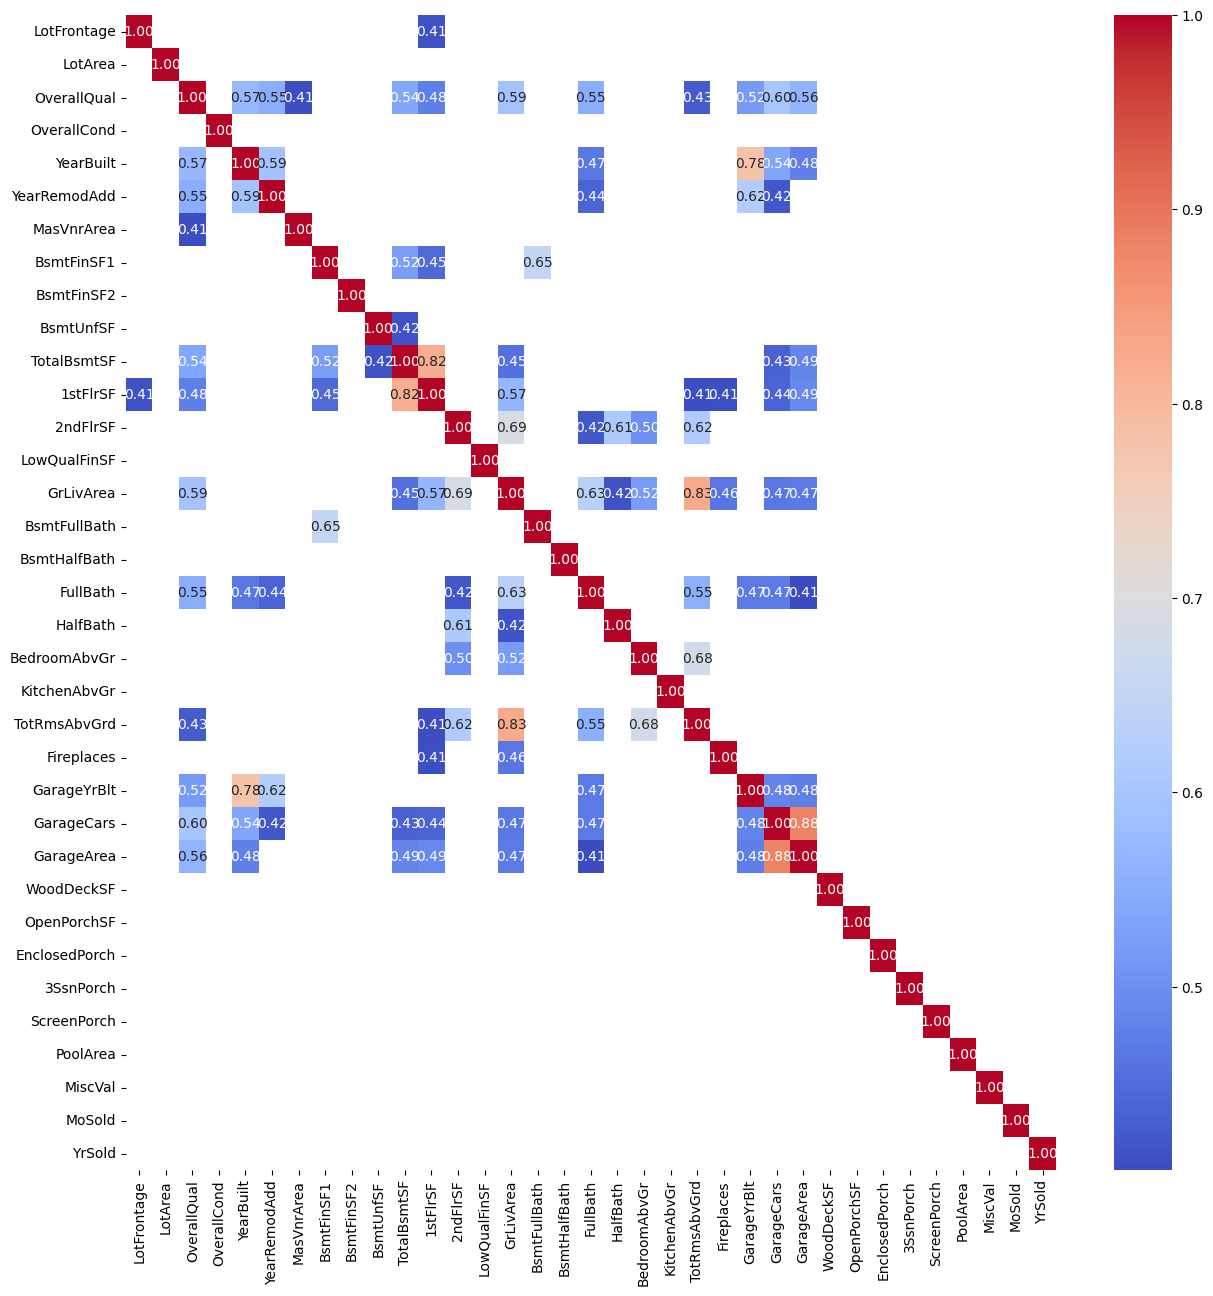

In [28]:
plt.figure(figsize = (15, 15))

correlation_threshold = 0.4
correlation_matrix = data[numerical_columns].corr()[data[numerical_columns].corr() > correlation_threshold]

sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f')

3 feature pairs stand out for having high correlation:

- `TotalBsmtSF` <-> `1stFlrSF` -> likely due to the basement often being considered the first floor
- `TotRmsAbvGrd` <-> `GrLivArea` -> likely because rooms directly factor into the living area
- `GarageYrBlt` <-> `YearBuilt` -> likely because the garage would have been built at the same time as the rest of the house

This means that we could remove 3 features for slightly less complexity while having minimal impact on the data. Why not?

In [29]:
data.drop(columns = ['TotalBsmtSF', 'TotRmsAbvGrd', 'GarageYrBlt'], inplace = True)

## Baseline Modeling

Let's create a base model now so that we can later optimize and see our improvements.

In [32]:
X = data
y = data_full.SalePrice

model = LinearRegression()

scores = cross_val_score(model, X, y, cv = 5)
scores.mean()

: 

: 

In [ ]:
model = LinearRegression().fit(X, y) # Fit model

permutation_score = permutation_importance(model, X, y, n_repeats=100) # Perform Permutation

importance_df = pd.DataFrame(np.vstack((X.columns,
                                        permutation_score.importances_mean)).T) # Unstack results

importance_df.columns=['feature','feature importance']

importance_df.sort_values(by="feature importance", ascending = False) # Order by importance